# Attribute Importance for Concept Drift - Primary and Secondary Drift Detection in one dataset

This notebook allows to detect primary and related secondary driftpoints according to the master thesis' framework.

The user specifies a file path for the dataset to analyze and builds the primary as well as secondary drift detectors.

Outputs are graphs as well as drift point lists.

## Setup
### Imports

In [1]:
# imports
import helper
from pm4py.objects.log.importer.xes import importer as xes_importer

from processdrift.framework import drift_detection
from processdrift.framework import drift_explanation
from processdrift.framework import feature_extraction
from processdrift.framework import pop_comparison
from processdrift.framework import windowing
import math
import pandas as pd

### Data settings and event log loading

In [2]:
# data settings
data_file_path = 'data/synthetic/attribute_drift/sudden_3_attribute_values/10000/cf10k_0bbd4c9b-97ca-4594-ad55-32d3686e7756.xes' # + 'data\\synthetic\\maardji et al 2013_xes_attributes\\logs\\cb\\cb2.5k.xes' # 

# load event log
event_log = xes_importer.apply(data_file_path)

c:\Users\Lennart\Tools\Anaconda3\envs\concept_drift\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 10000/10000 [00:07<00:00, 1311.52it/s]


### Configure Primary Drift Detector

In [3]:
# # alternative 1: ProDrift Drift detector
# primary_process_drift_detector = drift_detection.DriftDetectorProDrift(path_to_prodrift='ProDrift2.5/ProDrift2.5.jar',
#                                                                         drift_detection_mechanism='runs',
#                                                                         window_size=200,
#                                                                         window_mode='adaptive',
#                                                                         detect_gradual_as_well=False)

In [4]:
# alternative 2: Configure custom drift detector
# the user can select 
# - a primary feature extractor, specifying which primary axis feature to use
# - a window generator (fixed size or adaptive) incl. the window sizes and further settings
# - a population comparer
# - a threshold for detecting the change points

# primary_feature_extractor = feature_extraction.RelationshipTypesCountFeatureExtractor('Relationship types count')
# primary_window_generator = windowing.FixedSizeWindowGenerator(window_size=150, slide_by=1)
# primary_population_comparer = pop_comparison.HotellingsTSquaredPopComparer()
# primary_threshold = 0.5
# primary_process_drift_detector = drift_detection.DriftDetector(primary_feature_extractor, 
#                                                                primary_window_generator,
#                                                                primary_population_comparer, 
#                                                                threshold=primary_threshold)

In [5]:
# alternative 3: drift detector true known
primary_process_drift_detector = drift_detection.DriftDetectorTrueKnown(helper.get_change_points_maardji_et_al_2013(len(event_log)))

### Configure Secondary Drift Detectors

The user can specify a list of secondary drift detectors.

In [6]:
window_size = 100
slide_by = 10
secondary_window_generator = windowing.AdaptiveWindowGenerator(window_size, slide_by=slide_by)
secondary_population_comparer = pop_comparison.ChiSquaredComparer()
secondary_threshold = 0.05
secondary_exclude_attributes = ['concept:name']
max_distance = 300

phi = math.ceil(window_size / slide_by / 2)
rho = 1
print(f"phi={phi}, rho={rho}")

change_point_extractor = drift_detection.PhiFilterChangePointExtractor(secondary_threshold, phi, rho)

secondary_drift_detectors = drift_detection.get_all_attribute_drift_detectors(event_log,
                                                                         secondary_window_generator, 
                                                                         secondary_population_comparer, 
                                                                         exclude_attributes=secondary_exclude_attributes,
                                                                         change_point_extractor=change_point_extractor)

phi=5, rho=1


In [7]:
def detect_all_drifts():
    [secondary_drift_detector.get_changes(event_log, around_change_points=[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000], max_distance=300) for secondary_drift_detector in secondary_drift_detectors]

In [8]:
import time
start_time = time.perf_counter()
results1 = [secondary_drift_detector.get_changes(event_log, around_change_points=[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000], max_distance=300) for secondary_drift_detector in secondary_drift_detectors]
total_time = time.perf_counter() - start_time
print(total_time)

3.042486699996516


In [9]:
from joblib import Parallel, delayed
import time

start_time = time.perf_counter()
results2 = Parallel(n_jobs=-1)(delayed(secondary_drift_detector.get_changes)(event_log, around_change_points=[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000], max_distance=300) for secondary_drift_detector in secondary_drift_detectors)
total_time = time.perf_counter() - start_time
print(total_time)

20.70414280006662


In [10]:
import multiprocessing as mp
start_time = time.perf_counter()

print(mp.cpu_count())
# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

around_change_points = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]
# Step 2: `pool.apply` the `howmany_within_range()`
results = [pool.apply(secondary_drift_detector.get_changes, args=(event_log, around_change_points, 300)) for secondary_drift_detector in secondary_drift_detectors]
# Step 3: Don't forget to close
pool.close() 
total_time = time.perf_counter() - start_time
print(total_time)

8
42.820106300059706


## Run the Change Point Explainer

In [11]:
# create the change point explainer
drift_explainer = drift_explanation.DriftExplainer(primary_process_drift_detector, secondary_drift_detectors)

# get the change point explanations
primary_and_secondary_changes = drift_explainer.get_primary_and_secondary_changes(event_log, max_distance=max_distance)

In [12]:
import cProfile
cProfile.run('drift_explainer.get_primary_and_secondary_changes(event_log, max_distance=max_distance)', 'profile.stats')

import pstats
p = pstats.Stats("profile.stats")
p.sort_stats(pstats.SortKey.CUMULATIVE)
p.print_stats()

Thu Jul  7 16:22:21 2022    profile.stats

         5271222 function calls (5248988 primitive calls) in 4.397 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    4.397    4.397 {built-in method builtins.exec}
        1    0.000    0.000    4.397    4.397 <string>:1(<module>)
        1    0.000    0.000    4.397    4.397 c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\framework\drift_explanation.py:24(get_primary_and_secondary_changes)
       10    0.000    0.000    4.392    0.439 c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\framework\drift_detection.py:42(get_changes)
       10    0.044    0.004    4.385    0.439 c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\framework\drift_detection.py:69(_get_change_series)
     5484    0.008    0.000    2.575    0.000 c:\Users\Lennart\Documents\1_Workspaces\explaini

In [13]:
!python gprof2dot.py -f pstats profile.stats -r pySPACE | dot -Tpng -o output.png

python: can't open file 'c:\\Users\\Lennart\\Documents\\1_Workspaces\\explaining_concept_drift\\gprof2dot.py': [Errno 2] No such file or directory


In [14]:
!gprof2dot profile.stats -f pstats | dot -Tpng -o output.png

In [ ]:
threshold = 0.05
phi = 2
rho = 2

change_series = pd.Series([1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1])
display(change_series)

change_point_extractor = drift_detection.PhiFilterChangePointExtractor(threshold, phi, rho)
change_point_extractor.get_change_points(change_series)

0     1
1     1
2     1
3     0
4     1
5     0
6     1
7     0
8     1
9     1
10    1
11    1
12    1
13    1
dtype: int64

[3]

<AxesSubplot:>

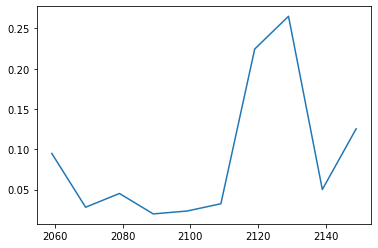

In [ ]:
primary_and_secondary_changes[1]['irrelevant_attribute_02']['change_series'].loc[2050:2150].plot()

In [ ]:
change_point_extractor.get_change_points(primary_and_secondary_changes[1]['irrelevant_attribute_02']['change_series'].loc[2050:2150])

[2069]

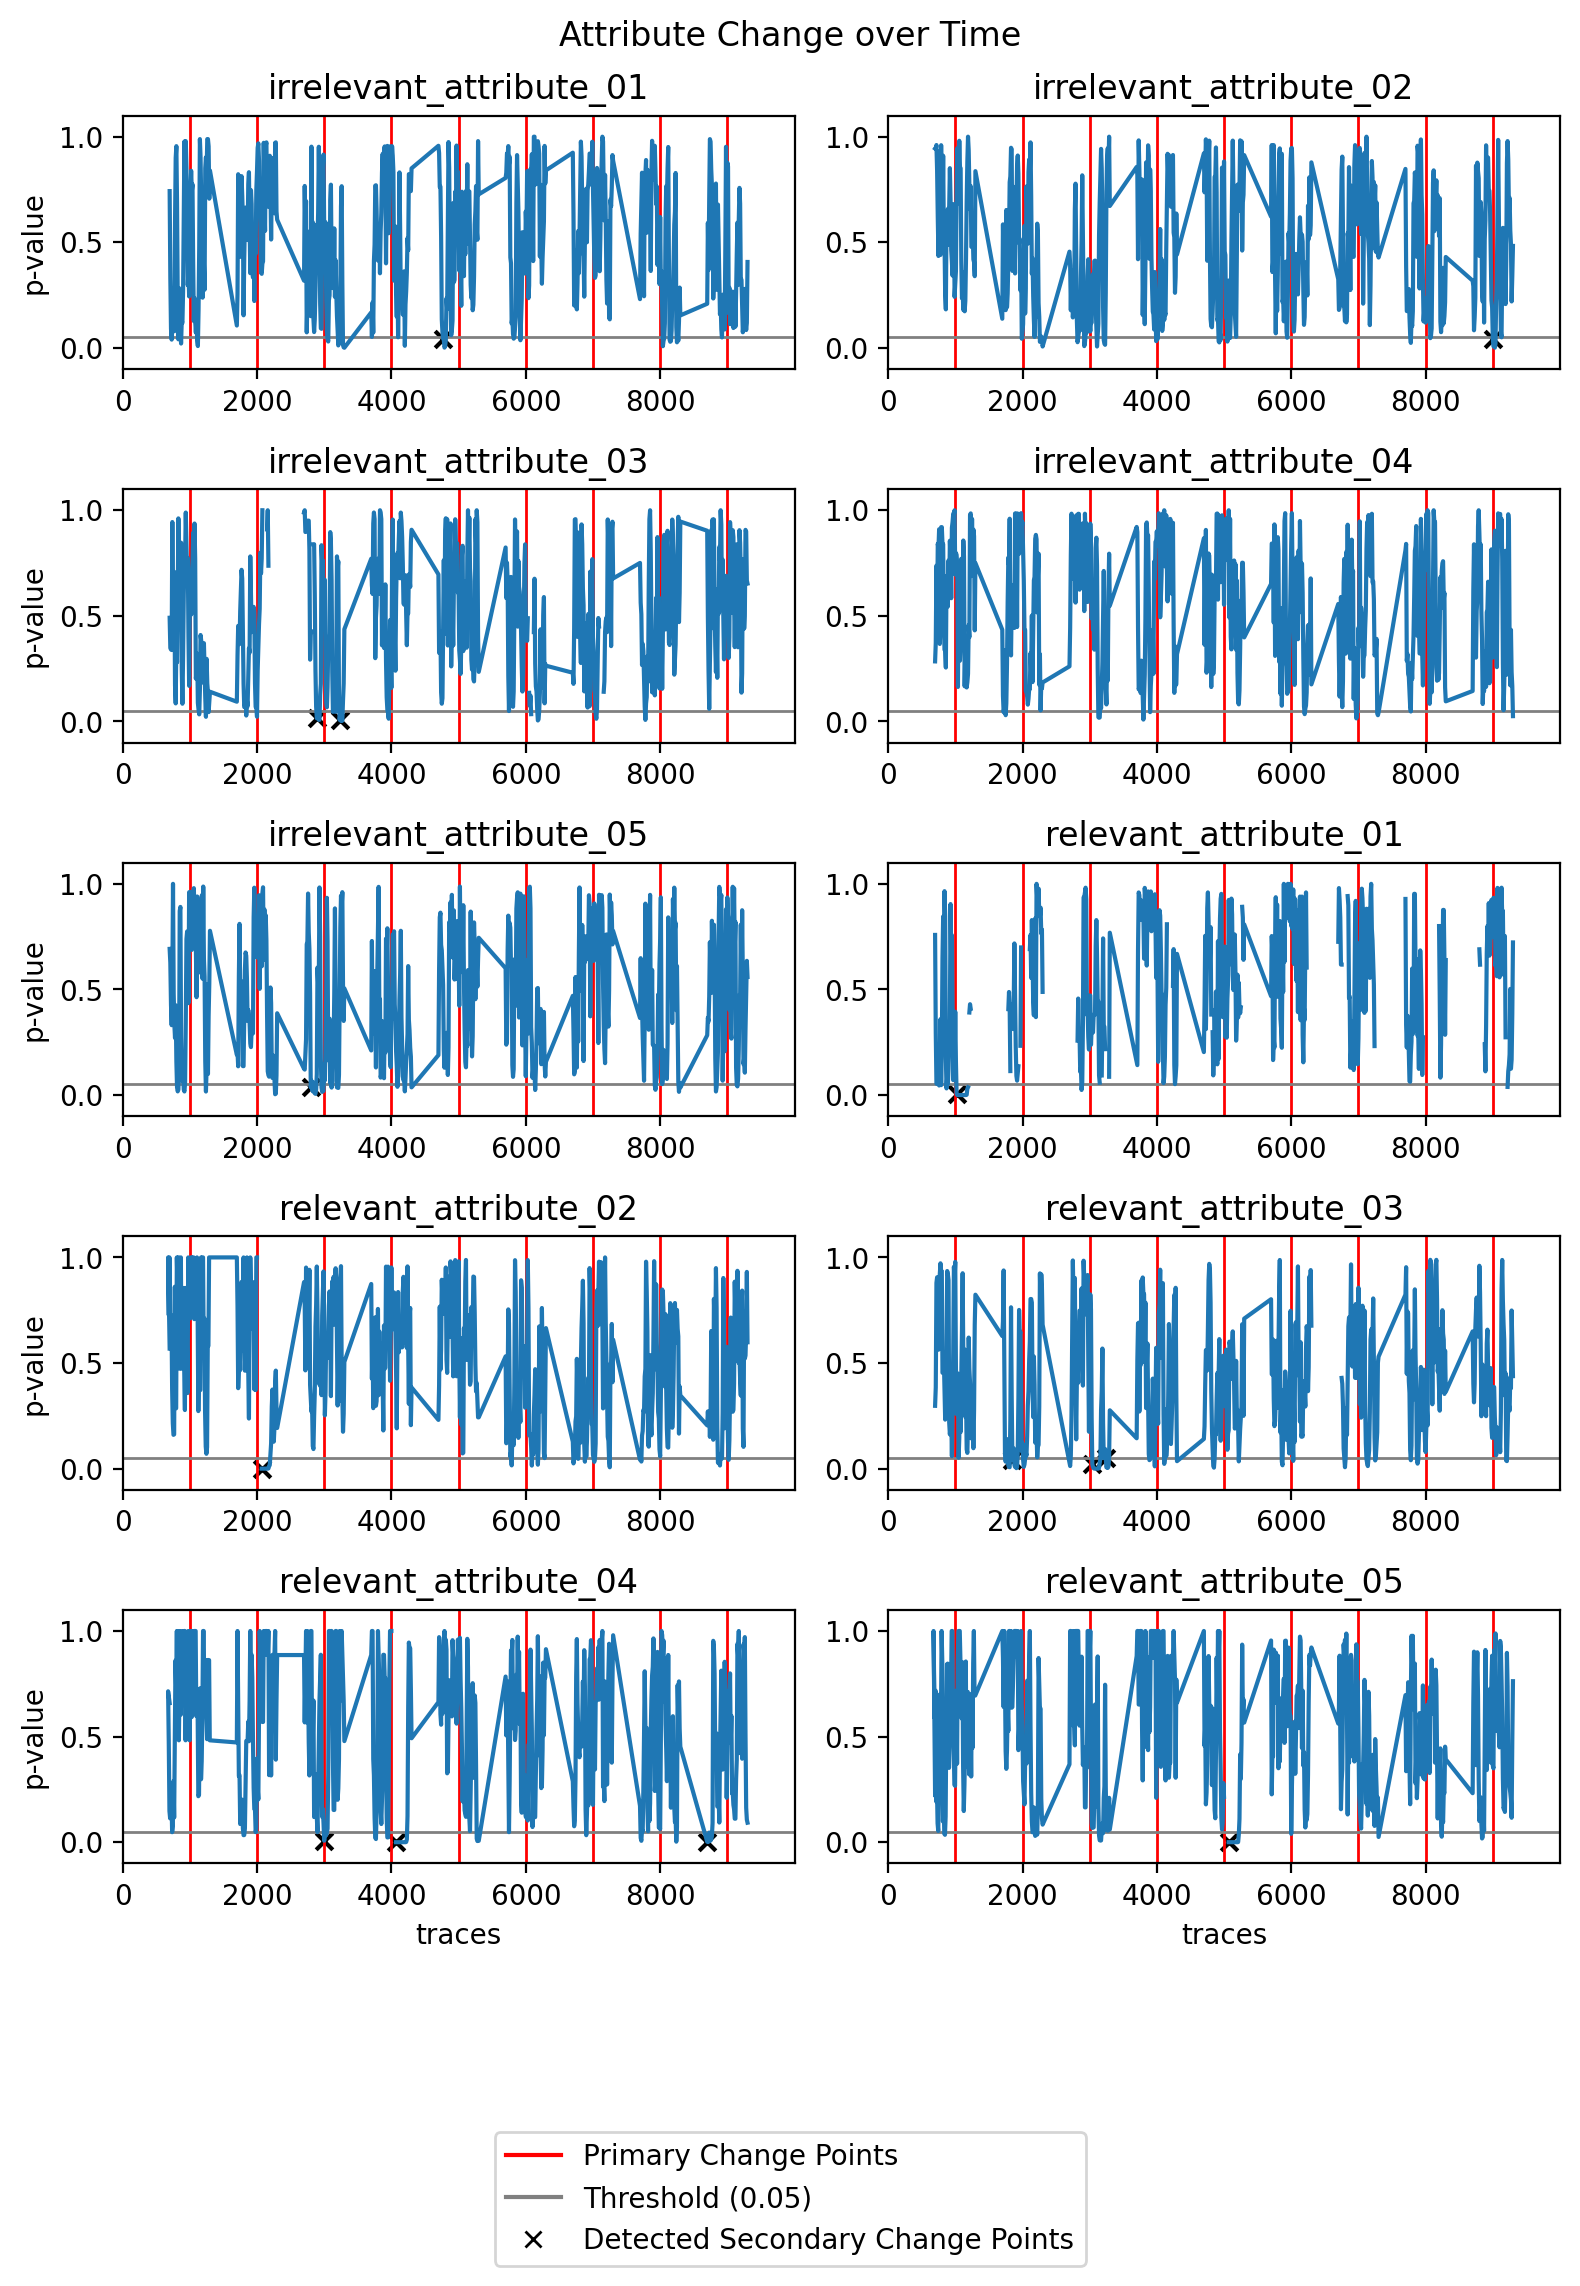

In [16]:
# plot the change point explanations
drift_explanation.plot_primary_and_secondary_changes(primary_and_secondary_changes)
pass

In [17]:
drift_explanation.get_possible_change_explanations(primary_and_secondary_changes, max_distance=200)

{1000: [{'detector': 'relevant_attribute_01',
   'change_point': 1019,
   'distance': 19}],
 2000: [{'detector': 'relevant_attribute_02',
   'change_point': 2069,
   'distance': 69},
  {'detector': 'relevant_attribute_03',
   'change_point': 1849,
   'distance': -151}],
 3000: [{'detector': 'relevant_attribute_04',
   'change_point': 2999,
   'distance': -1},
  {'detector': 'relevant_attribute_03', 'change_point': 3039, 'distance': 39},
  {'detector': 'irrelevant_attribute_03',
   'change_point': 2889,
   'distance': -111}],
 4000: [{'detector': 'relevant_attribute_04',
   'change_point': 4069,
   'distance': 69}],
 5000: [{'detector': 'relevant_attribute_05',
   'change_point': 5069,
   'distance': 69}],
 6000: [],
 7000: [],
 8000: [],
 9000: [{'detector': 'irrelevant_attribute_02',
   'change_point': 8999,
   'distance': -1}]}